# Image Retrieval

In [1]:
from tqdm import tqdm

import torch
from torchvision import models, transforms

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image

from torch.nn.functional import cosine_similarity
from torch.nn import functional as F

### **Helper Functions**

In [2]:
# Image transformation: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((86, 128)),
    transforms.ToTensor(),
])

# Function to load and preprocess the image
def load_image(path, transform):
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img)
    return img_tensor

##**1. Preprocessing**

In [21]:
# Img folder path and Save path (Change if needed)
img_path = 'data/images_mr'
query_path = 'data/query_img'
save_path = 'model/images_mr.pt'

### Save all image as Tensor

In [4]:
lists = [i for i in range(9908)]
images = []

for index in tqdm(lists):
    # Load image
    try:
        img_tensor = load_image(f'{img_path}/{index}.jpg', transform)
        images.append(img_tensor)
    except FileNotFoundError:
        print(f'Image file not found: {img_path}/{index}.jpg')

# Stack all image tensors into one big tensor
img_tensor = torch.stack(images)
print(img_tensor.shape)

# Save the tensor
torch.save(img_tensor, save_path)
print(f"Saved tensor to {save_path}.")

100%|██████████| 9908/9908 [00:09<00:00, 1078.61it/s]


torch.Size([9908, 3, 86, 128])
Saved tensor to model/images_mr.pt.


### Load a sample image

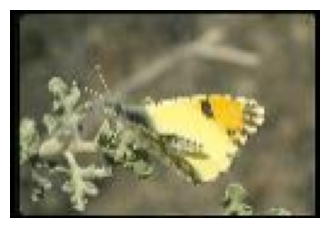

In [5]:
# Load the img tensor file
img_tensors = torch.load(save_path)

# Convert the tensor to a PIL image
image_pil = to_pil_image(img_tensors[0])

# Display the image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(image_pil)
plt.axis('off')  # Turn off axis numbers
plt.show()

##**3. Image Retrieval**

Img tensor shape: torch.Size([3, 86, 128])


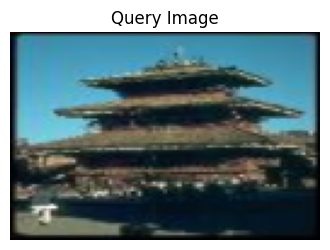

In [22]:
# Load query image
query_img_path = f'{query_path}/q2.jpg'
query_tensor = load_image(query_img_path, transform)
print(f'Img tensor shape: {query_tensor.shape}')

# Display query image
plt.figure(figsize=(4, 4))
plt.imshow(transforms.ToPILImage()(query_tensor))
plt.title("Query Image")
plt.axis('off')
plt.show()

In [8]:
# Flatten the query img
query_tensor_flat = query_tensor.view(1, -1)
print(f'Img tensor shape: {query_tensor_flat.shape}')

Img tensor shape: torch.Size([1, 33024])


In [10]:
# Load the saved tensor file containing all images
data_tensors = torch.load('model/images_mr.pt')
print(f'Data tensors shape: {data_tensors.shape}')
data_tensors_flat = data_tensors.view(data_tensors.size(0), -1)
print(f'Data tensors shape: {data_tensors_flat.shape}')

Data tensors shape: torch.Size([9908, 3, 86, 128])
Data tensors shape: torch.Size([9908, 33024])


### 3.1 Retrieval - Absolute Distance

In [11]:
# Calculate L1 distance (absolute difference)
distances = torch.abs(data_tensors_flat - query_tensor_flat)
distances = torch.sum(distances, dim=1)

Index: 3425, Distance: 0.0
Index: 3077, Distance: 5221.431640625
Index: 2611, Distance: 5247.2900390625
Index: 3109, Distance: 5289.16845703125
Index: 3445, Distance: 5358.61962890625
Index: 960, Distance: 5378.94873046875
Index: 4788, Distance: 5395.0078125
Index: 3094, Distance: 5435.6904296875


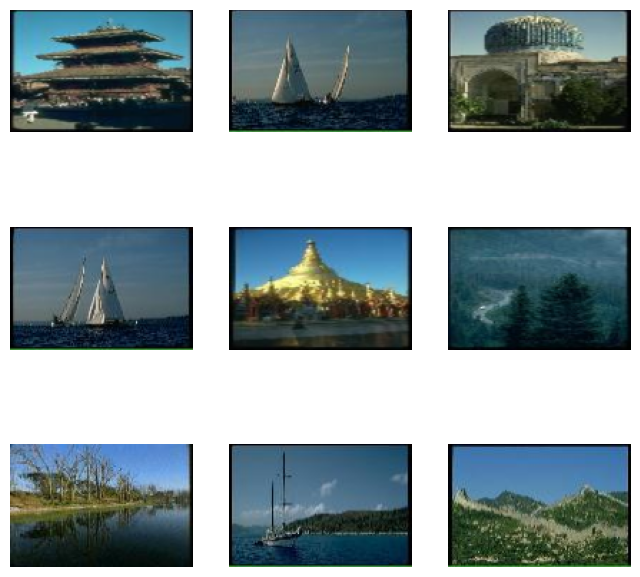

In [ ]:
# Sort the distances and get indices
sorted_indices = torch.argsort(distances, descending=False)

# Print top 8 values and their indices
for i in range(8):
    index = sorted_indices[i].item()
    distance = distances[index].item()
    print(f'Index: {index}, Distance: {distance}')

# Display top 8 similar images
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(columns * rows):
    index = sorted_indices[i].item()
    img = data_tensors[index]

    ax = fig.add_subplot(rows, columns, i + 1)
    ax.axis('off')
    ax.imshow(to_pil_image(img))

plt.show()

### 3.2 Retrival - Cosine Similarity

In [12]:
# Calculate cosine similarity
sims = cosine_similarity(query_tensor_flat, data_tensors_flat)

Index: 3425, Similarity: 0.999997615814209
Index: 3306, Similarity: 0.8691879510879517
Index: 4645, Similarity: 0.8683653473854065
Index: 3330, Similarity: 0.8676211833953857
Index: 3374, Similarity: 0.867255449295044
Index: 4317, Similarity: 0.8664509057998657
Index: 3053, Similarity: 0.8658316135406494
Index: 3780, Similarity: 0.8647940158843994


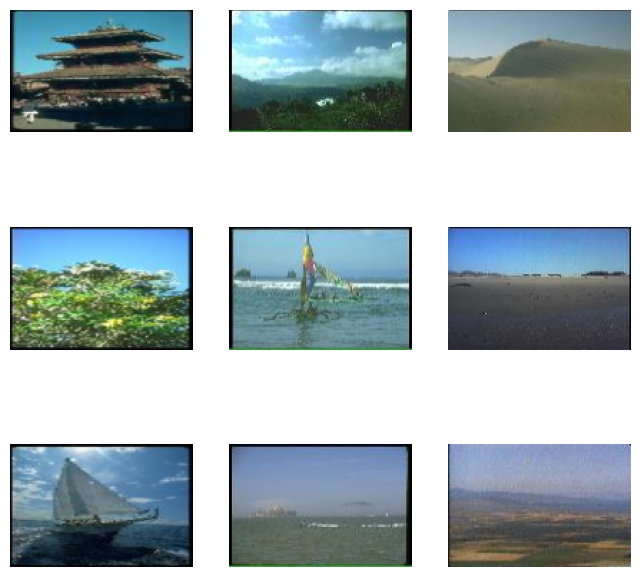

In [13]:
# Sort the similarities and get indices
sorted_indices = torch.argsort(sims, descending=True)

# Print top 8 values and their indices
for i in range(8):
    index = sorted_indices[i].item()
    similarity = sims[index].item()
    print(f'Index: {index}, Similarity: {similarity}')

# Display top 8 similar images
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(columns * rows):
    index = sorted_indices[i].item()
    img = data_tensors[index]

    ax = fig.add_subplot(rows, columns, i + 1)
    ax.axis('off')
    ax.imshow(to_pil_image(img))

plt.show()

### 3.3 Retrieval - Using Pretrained ResNet18 for features extraction

#### 3.3.1 Resnet18 Model

In [17]:
# Load the pretrained ResNet18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Remove the last layer to use as a feature extractor
modules = list(resnet18.children())[:-1]
resnet18 = torch.nn.Sequential(*modules)

resnet18.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#### 3.3.2 Preprocessing all images to features Tensor

In [18]:
# Function to preprocess and extract features
def extract_features(tensor, model):
    with torch.no_grad():
        # Add batch dimension and get features
        features = model(tensor.unsqueeze(0))
        # Flatten the features
        features = features.view(features.size(0), -1)
        return features

# Extract features for each image and store them
feature_list = []
for tensor in data_tensors:
    # print(tensor.unsqueeze(0).shape)
    features = extract_features(tensor, resnet18)
    feature_list.append(features)

# Stack all features into a single tensor
feature_tensor = torch.stack(feature_list).squeeze()
print(feature_tensor.shape)
torch.save(feature_tensor, 'model/images_mr_features.pt')

torch.Size([9908, 512])


#### 3.3.3 Cosine Similarity with Resnet18 extracted features

Index: 3425, Similarity: 1.0
Index: 3509, Similarity: 0.7664079070091248
Index: 3214, Similarity: 0.7649728059768677
Index: 3793, Similarity: 0.7572246193885803
Index: 3667, Similarity: 0.7564090490341187
Index: 370, Similarity: 0.7485784292221069
Index: 235, Similarity: 0.7470497488975525
Index: 3840, Similarity: 0.7444981932640076


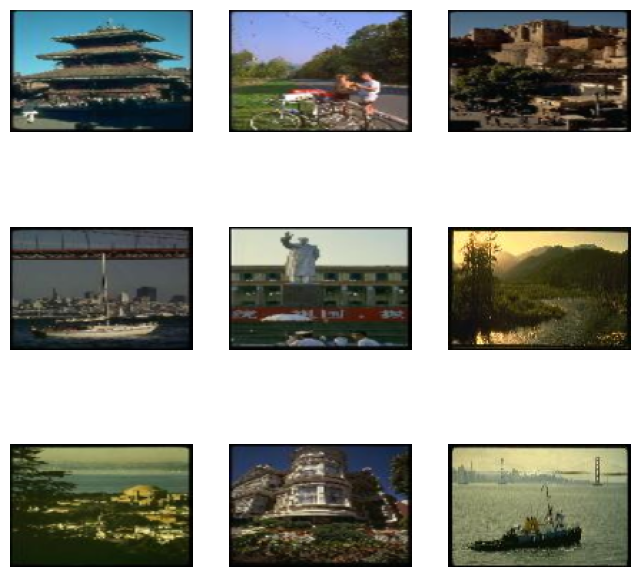

In [23]:
# Load the query image and extract features
query_tensor = load_image(query_img_path, transform)
query_features = extract_features(query_tensor, resnet18)

# Load the feature tensor
feature_tensor = torch.load('model/images_mr_features.pt')

# Calculate cosine similarity
sims = cosine_similarity(query_features, feature_tensor)

# Sort the similarities and get indices
sorted_indices = torch.argsort(sims, descending=True)

# Print top 8 values and their indices
for i in range(8):
    index = sorted_indices[i].item()
    similarity = sims[index].item()
    print(f'Index: {index}, Similarity: {similarity}')

# Display top 8 similar images
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(columns * rows):
    index = sorted_indices[i].item()
    img = data_tensors[index]

    ax = fig.add_subplot(rows, columns, i + 1)
    ax.axis('off')
    ax.imshow(to_pil_image(img))

plt.show()